In [2]:
import numpy as np
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt

prefix = "P2"
iData = az.from_netcdf(f"../results/{prefix}_result_new.nc")

In [3]:
from data_handling import Data

core_id = prefix
arch_data = pd.read_csv("../dat/real_arch_data.csv")
sed_data = pd.read_csv(f"../dat/sed_data/{core_id}_prepared.csv")
adm_data = pd.read_csv(f"../dat/sed_data/{core_id}_adm_data.csv")
arch = Data(arch_data)
sed = Data(sed_data, adm_data)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/lbohsung/sedprep/sedprep/utils.py:470: UserWarning: c++-accelerated version could not be loaded. Falling back to pymagglobal.


In [4]:
depths = sed.modelled_depths
all_ages = iData.posterior[f"c_ages_{core_id}"].values
# ages = all_ages[chain, :].T
ages = all_ages.reshape(-1, depths.shape[0]).T

AttributeError: 'Data' object has no attribute 'modelled_depths'

Chain: 0
Chain: 1
Chain: 2
Chain: 3


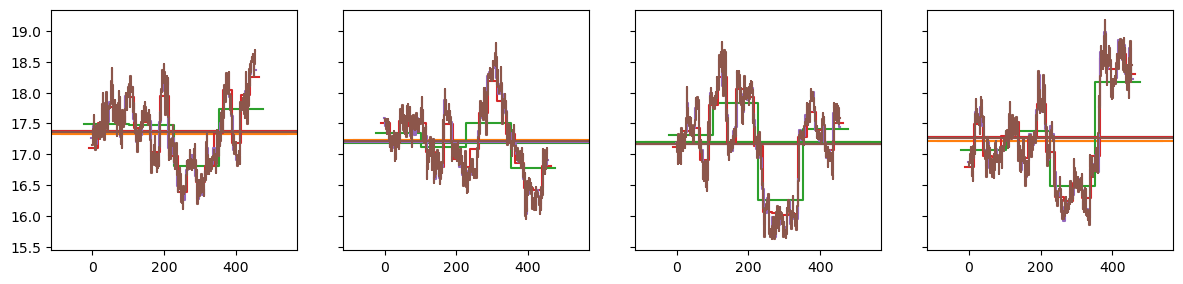

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
fig.tight_layout()
factor = 3.5
for chain in range(4):
    print(f"Chain: {chain}")
    mean_stds, min_alphas = [], []
    x = iData.posterior[f"x_{core_id}"].values[chain]
    for level in range(1, sed.levels_dict["n_levels"]):
        apl = iData.posterior[f"alphas_level_{level+1}_{core_id}"]

        # if level == 0:
        #     axs[chain].axhline(np.array(apl)[chain].mean(), color=f"C{level}")
        #     mean_stds.append(apl.values[chain][:60].std(axis=1).mean())
        #     min_alphas.append(apl.values[chain].min())
        #     continue
        levels_dict = sed.levels_dict[f"{level+1}"]

        num = levels_dict["nK"]
        apl = np.array(apl)[chain].reshape(-1, num).T
        mean = apl.mean(axis=1)
        std = apl.std(axis=1)
        # print(apl.std(axis=1).mean())
        # if level==5:
        # print(apl.shape)
        mean_stds.append(apl.std(axis=1).mean())
        min_alphas.append(apl.min())
        # print(level, np.argmax(mean).flatten().item(), num)
        # brks = levels_dict['brks']
        brks = np.copy(levels_dict["brks"])
        brks *= sed.c_depth_top[-1] - sed.c_depth_top[0]
        brks += sed.c_depth_top[0]
        axs[chain].step(
            brks, np.concatenate([[mean[0]], mean]), color=f"C{level}"
        )
        # print(sed.acc_mean - np.mean(mean))
        axs[chain].axhline(np.mean(mean), color=f"C{level}")
        # print(sed.acc_mean)
        # print(np.mean(mean))
        # print("--------")
    # axs[chain].step(
    #     brks,
    #     np.concatenate([[x.mean(axis=0)[0]], x.mean(axis=0)]),
    #     color=f"black",
    # )
    # print(mean_stds)
    # axs[chain].axhline(sed.acc_mean, c="C0")
    # axs[chain].axhline(sed.acc_mean + sed.acc_mean / 5, ls="--", c="black")
    # axs[chain].axhline(sed.acc_mean - sed.acc_mean / 2, ls="--", c="black")
    # axs[chain].axhline(sed.acc_mean * factor, c="black")
    # axs[chain].axhline(sed.acc_mean / factor, c="black")
    # axs[chain].axhline(75, c="black")
    # plt.ylim(0, 10)

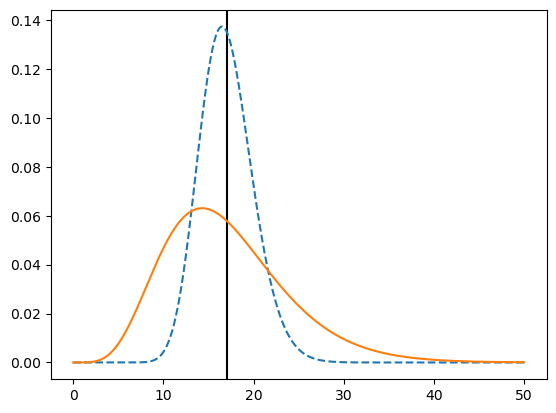

In [15]:
from constants import acc_shape
from scipy.stats import gamma
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

inp = np.linspace(0, 50, 1000)
# plt.plot(inp, sigmoid(-1 * (sed.acc_mean/4 - inp)))

acc_mean = sed.acc_mean
plt.axvline(acc_mean, color="black")
acc_shape = 8
acc_shape_adj = acc_shape * (sed.levels_dict["n_levels"] - 1) / sed.levels_dict["multi_parent_adj"]
plt.plot(inp, gamma.pdf(inp, a=acc_shape_adj, scale=1/(acc_shape_adj / acc_mean)), ls="--")
acc_shape = 1.5
acc_shape_adj = acc_shape * (sed.levels_dict["n_levels"] - 1) / sed.levels_dict["multi_parent_adj"]
plt.plot(inp, gamma.pdf(inp, a=acc_shape_adj, scale=1/(acc_shape_adj / acc_mean)))

In [5]:
from constants import acc_shape
from scipy.stats import gamma

chain = "all"
if chain != "all":
    ages = all_ages[chain, :].T
else:
    ages = all_ages.reshape(-1, depths.shape[0]).T
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.errorbar(
    adm_data["t"],
    adm_data["depth"],
    xerr=adm_data["dt"],
    color="black",
    ls="",
    marker=".",
    alpha=0.7,
    zorder=1,
    label="adm observations",
)
ax.plot(
    (1950 - sed.adm_t) + sed.adm_dt,
    sed.adm_depth,
    color="black",
    ls="--",
    alpha=0.7,
    zorder=1,
)
ax.plot(
    (1950 - sed.adm_t) - sed.adm_dt,
    sed.adm_depth,
    color="black",
    ls="--",
    alpha=0.7,
)
ax.plot(1950 - ages, depths, zorder=2, color="grey", alpha=0.005)
ax.plot(
    1950 - ages.mean(axis=1),
    depths,
    zorder=3,
    color="C2",
    label="posterior mean",
)
# ax.plot(sed.t, sed.depth, color='C3', ls='--')
ax.set_xlabel("Year")
ax.set_ylabel("Depth [cm]")
ax.invert_yaxis()
# ax.legend(frameon=False)
# ax.set_xlim(-8000, -2000)
# ax.set_ylim(300, 100)

# acc_shape = 10
# acc_shape_adj = acc_shape * (sed.levels_dict["n_levels"] - 1) / sed.levels_dict["multi_parent_adj"]
# ratio = 10
# # beta = 1/ratio
# beta = acc_shape_adj / sed.acc_mean
# # alpha = sed.acc_mean * beta
# alpha = acc_shape_adj
# alpha_0_samps = gamma.rvs(a=alpha, scale=1/beta, size=30)
# print(f"old beta: {acc_shape_adj / sed.acc_mean}")
# print(f"beta with std = {ratio} * acc_mean: {beta}")
# inp = np.linspace(0, max(sed_data.depth), 100)
# [plt.plot(2000-alpha_0*inp, inp, c="C0") for alpha_0 in alpha_0_samps]
# plt.plot(2000-sed.acc_mean*inp, inp, c="C1")
ax.legend()
plt.show()
# 0.022

NameError: name 'all_ages' is not defined

In [7]:
a_s = iData.posterior[f"lock_in_{core_id}"].values.reshape(-1, 4).T
b_s = np.cumsum(a_s, axis=0)
b_s_mean = b_s.mean(axis=1)
iData.posterior[f"lock_in_{core_id}"].values.mean(axis=1)

array([[ 8.0308852 ,  9.72026771, 12.37828861, 14.34277652],
       [ 8.03881887,  9.14945836, 11.79118736, 14.15043916],
       [ 8.16273158,  8.75825812, 12.40623602, 13.42862329],
       [ 7.85315586,  8.94007061, 12.11446524, 13.95244468]])

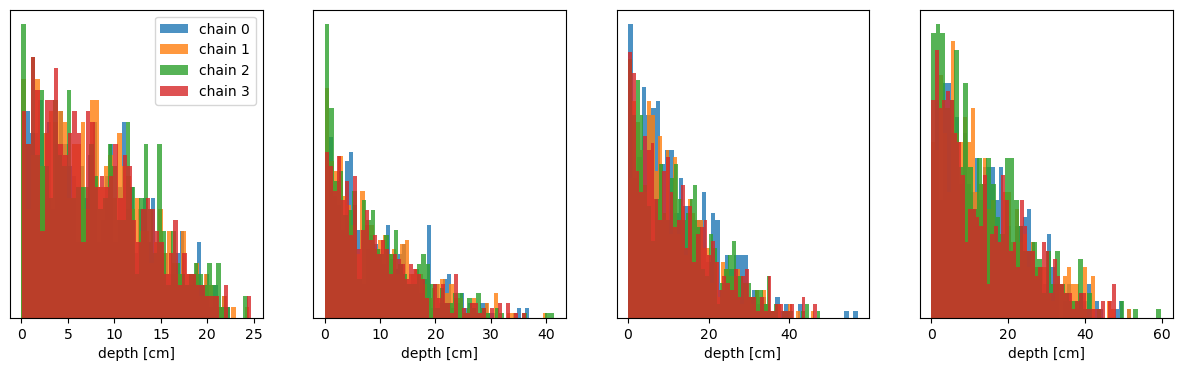

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
all_a_s = iData.posterior[f"lock_in_{core_id}"].values
for it in range(4):
    for chain in range(4):
        axs[it].hist(
            all_a_s[chain, :, it],
            bins=50,
            alpha=0.8,
            color=f"C{chain}",
            label=f"chain {chain}",
        )
        axs[it].set_yticks([])
        axs[it].set_xlabel("depth [cm]")
axs[0].legend()

Chain: 0, Subsection: A, Mean: 48.305124299817905
Chain: 1, Subsection: A, Mean: 48.70957410686813
Chain: 2, Subsection: A, Mean: 44.489927889171085
Chain: 3, Subsection: A, Mean: 43.0046124262287
Chain: 0, Subsection: B, Mean: -11.438810047652467
Chain: 1, Subsection: B, Mean: -14.68871047935898
Chain: 2, Subsection: B, Mean: -12.034665919212955
Chain: 3, Subsection: B, Mean: -12.28737914983898


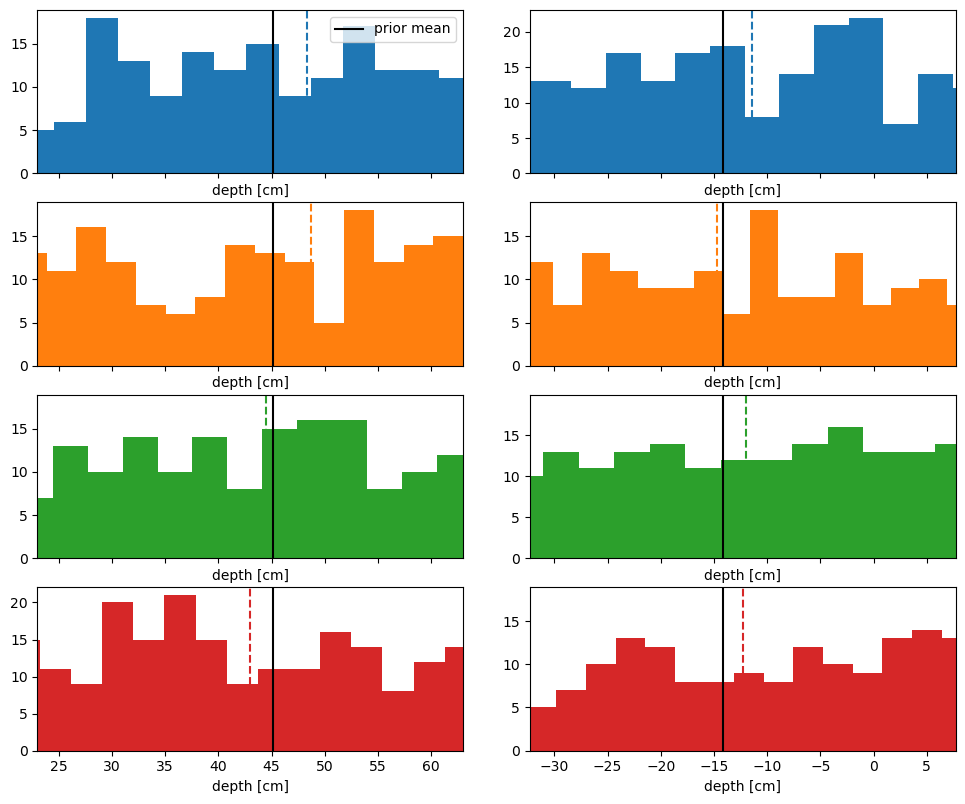

In [9]:
fig, axs = plt.subplots(
    4,
    len(sed.subcores.keys()),
    figsize=(5 * len(sed.subcores.keys()), 8),
    sharex="col",
)
fig.tight_layout()
inp = np.linspace(-20, 20, 1000)
for i, sub in enumerate(sed.subcores.keys()):
    offsets = iData.posterior[f"offset_{sub}"].values
    for chain in range(4):
        ax = axs[chain, i] if len(sed.subcores.keys()) > 1 else axs[chain]
        # ax.hist(
        #     np.random.normal(sed.subcores[sub][1], 50, size=800),
        #     bins=200,
        #     color="grey",
        #     alpha=0.5,
        # )
        ax.hist(offsets[chain], bins=100, color=f"C{chain}")
        print(
            f"Chain: {chain}, Subsection: {sub}, Mean: {np.mean(offsets[chain])}"
        )
        ax.axvline(np.mean(offsets[chain]), ls="--", color=f"C{chain}")
        ax.axvline(sed.subcores[sub][1], c="black", label="prior mean")
        # axs[chain].set_yticks([])
        ax.set_xlabel("depth [cm]")
        ax.set_xlim(np.mean(offsets[chain])-20, np.mean(offsets[chain])+20)
    axs[0, 0].legend() if len(sed.subcores.keys()) > 1 else axs[0].legend()

In [10]:
for i in range(4):
    print(iData.posterior[f"R_{core_id}"].values[i].mean())

0.4963257638801153
0.48972577509192944
0.5011094806759713
0.5007627640088089


Text(0.5, 0, 'depth [cm]')

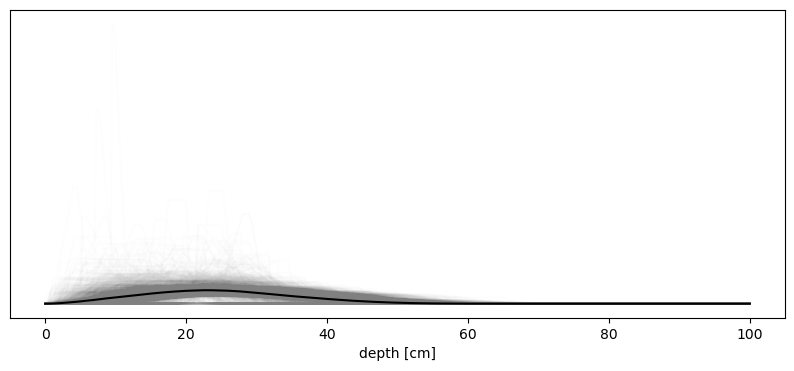

In [11]:
depth = np.linspace(0, 100, 401)
beta = 2 / (b_s[3] + b_s[2] - b_s[1] - b_s[0])
F_01 = 0.0
F_12 = (
    beta[None, :]
    * (depth[:, None] - b_s[0, None, :])
    / (b_s[1] - b_s[0])[None, :]
)
F_23 = beta[None, :]
F_34 = (
    beta[None, :]
    * (b_s[3, None, :] - depth[:, None])
    / (b_s[3] - b_s[2])[None, :]
)
F_4x = 0.0

ind_12 = (b_s[0, None, :] < depth[:, None]) * (
    depth[:, None] <= b_s[1, None, :]
)
ind_23 = (b_s[1, None, :] < depth[:, None]) * (
    depth[:, None] <= b_s[2, None, :]
)
ind_34 = (b_s[2, None, :] < depth[:, None]) * (
    depth[:, None] <= b_s[3, None, :]
)

lis = ind_12 * F_12 + ind_23 * F_23 + ind_34 * F_34

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(depth, lis, alpha=0.01, color="grey")
ax.plot(depth, lis.mean(axis=1), alpha=1, color="black")
ax.set_yticks([])
ax.set_xlabel("depth [cm]")

In [12]:
np.array(iData.posterior[f"f_shallow_{core_id}"]).mean(axis=1)

array([0.60948245, 0.61371948, 0.5908549 , 0.60157026])

In [3]:
iData = az.from_netcdf(f"../results/{prefix}_result_prior_full.nc")
coeffs = iData.posterior[f'gs_at_knots'].values.reshape(-1, 35, 185)#.reshape(-1, 35, 161)

In [124]:
from pymagglobal.utils import REARTH, nez2dif
nez_s = np.einsum('ij, i...->j...', sed.base, coeffs.transpose(1, 2, 0))
d_s, i_s, f_s = nez2dif(*nez_s)

t_min=min(min(sed_data.t), -6000) - 1000
t_max=2000
step=50
mcmc_knots = np.arange(t_min, t_max + step, step)

In [ ]:
from scipy.interpolate import BSpline
from utils import interp_adm_np

c_ages = iData.posterior[f"c_ages_{core_id}"].values.reshape(
    -1,
    sed.modelled_depths.shape[0],
)
# alpha_0 = iData.posterior[f"alphas_level_1_{core_id}"].values
# alpha_0 = alpha_0.flatten().mean()
alpha_0 = np.array([sed.acc_mean])

t_i = 1950 - c_ages.mean(axis=0)
d_i = sed.modelled_depths

spl_t_knots = np.concatenate(([-t_i[0]], -t_i, [-t_i[-1]]))
_t2dspl = BSpline(spl_t_knots, d_i, 1)

err_t2d = _t2dspl.derivative()(_t2dspl.t[1:-1]).max()

def t2d(x):
    return _t2dspl(-x)

spl_d_knots = np.concatenate(([d_i[0]], d_i, [d_i[-1]]))
d2t = BSpline(spl_d_knots, t_i, 1)

knots_d = interp_adm_np(-mcmc_knots, -t_i, sed.modelled_depths, alpha_0)
a_s = iData.posterior[f"lock_in_{core_id}"].values.reshape(-1, 4)
# a_s = a_s.mean(axis=0)
d_io = sed.depth[None, :] - knots_d[:, None]

bs = np.cumsum(a_s.mean(axis=0), axis=0)
beta = 2 / (bs[3] + bs[2] - bs[1] - bs[0])
# F_01 = 0.
F_12 = beta * (d_io - bs[0]) ** 2 / 2 / (bs[1] - bs[0])
F_23 = beta * (d_io - (bs[1] + bs[0]) / 2)
F_34 = beta * (
    -(d_io**2 / 2 - bs[3] * d_io + bs[2] ** 2 / 2) / (bs[3] - bs[2])
    - (bs[1] + bs[0]) / 2
)
F_4x = 1

# ind_01 = d_io <= bs[0]
ind_12 = (bs[0] < d_io) * (d_io <= bs[1])
ind_23 = (bs[1] < d_io) * (d_io <= bs[2])
ind_34 = (bs[2] < d_io) * (d_io <= bs[3])
ind_4x = bs[3] < d_io

ints = ind_12 * F_12 + ind_23 * F_23 + ind_34 * F_34 + ind_4x * F_4x

weights = ints[1:] - ints[:-1]
# # Normalize, i.e. increase the weight of the present day field for
# # sediments that see "the future" due to incomplete lockin
# # XXX there might be a more efficient way to do this
today_component = np.zeros(len(mcmc_knots) - 1)
today_component[-1] = 1
weights += (1 - weights.sum(axis=0))[None, :] * today_component[:, None]
coeffs_s = np.einsum("ijk, jl->ilk", coeffs.reshape(-1, 35, len(mcmc_knots)).transpose(0, 2, 1)[:, :-1, :], weights)
nez_s = np.einsum('ij, i...->j...', sed.base, coeffs_s.transpose(2, 1, 0))
d_s_shifted, _, _ = nez2dif(*nez_s)

In [ ]:
c_ages_samps = (
    posterior[f"c_ages_{core_id}"]
    .values.reshape(-1, sed.modelled_depths.shape[0])[::step_size]
    .T
)

Text(0, 0.5, 'modified prior')

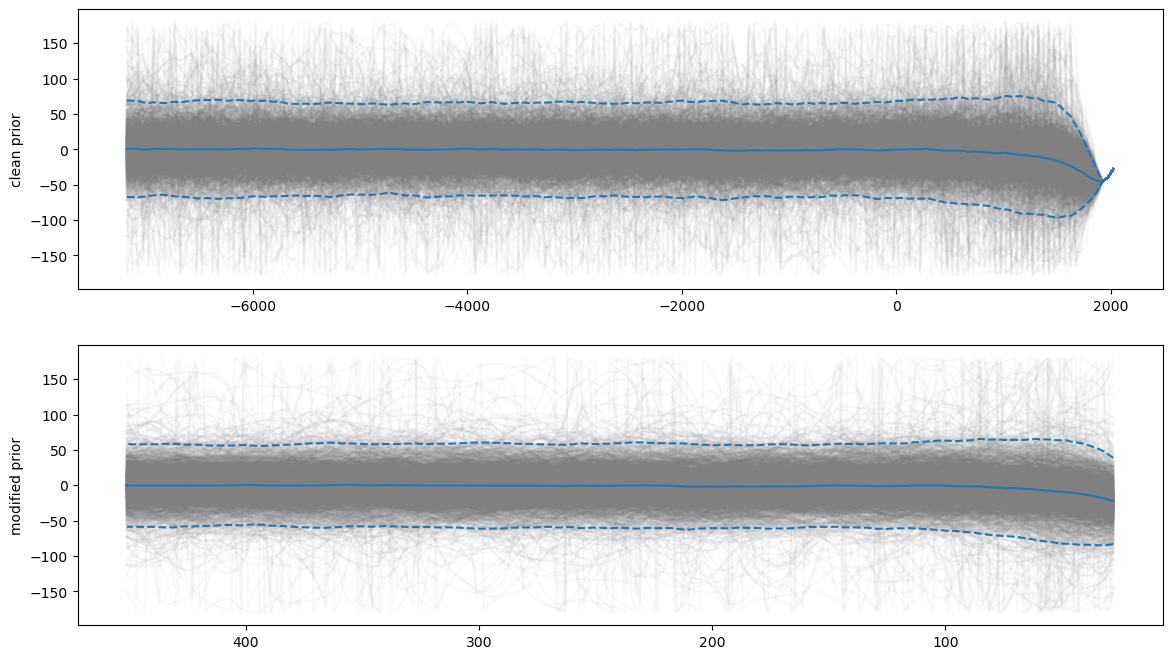

In [143]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))
axs[0].plot(mcmc_knots, d_s, c="gray", alpha=0.05)
axs[0].plot(mcmc_knots, np.mean(d_s, axis=1), c="C0")
axs[0].plot(mcmc_knots, np.mean(d_s, axis=1) + 2*np.std(d_s, axis=1), c="C0", ls="--")
axs[0].plot(mcmc_knots, np.mean(d_s, axis=1) - 2*np.std(d_s, axis=1), c="C0", ls="--")
axs[0].set_ylabel("clean prior")
axs[1].plot(sed.depth, d_s_shifted, c="gray", alpha=0.05)
axs[1].plot(sed.depth, np.mean(d_s_shifted, axis=1), c="C0")
axs[1].plot(sed.depth, np.mean(d_s_shifted, axis=1) + 2*np.std(d_s_shifted, axis=1), c="C0", ls="--")
axs[1].plot(sed.depth, np.mean(d_s_shifted, axis=1) - 2*np.std(d_s_shifted, axis=1), c="C0", ls="--")
axs[1].invert_xaxis()
axs[1].set_ylabel("modified prior")

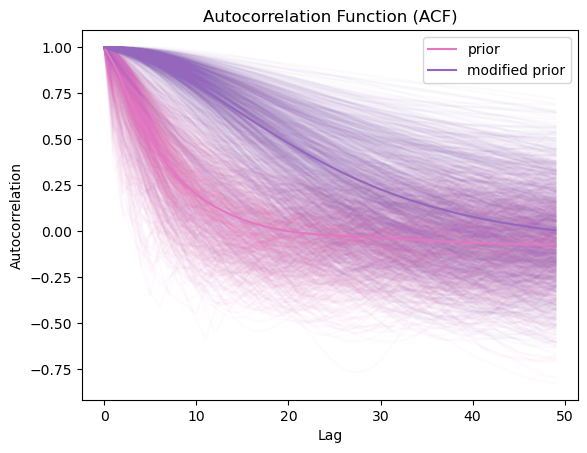

In [132]:
def compute_acf(series, max_lag):
    N = len(series)
    mu = np.mean(series)
    var = np.var(series)
    acf_vals = []
    for k in range(max_lag + 1):
        numerator = np.sum((series[:N-k] - mu) * (series[k:] - mu))
        acf_k = numerator / ((N - k) * var)
        acf_vals.append(acf_k)
    return acf_vals

n_lags = 50
# acf_values_shifted = compute_acf(I_sed.T[:, 0], max_lag=n_lags)
acf_shifted = np.array([compute_acf(d_s_shifted[:, i], max_lag=n_lags-1) for i in range(1000)])
acf_normal = np.array([compute_acf(d_s[:, i], max_lag=n_lags-1) for i in range(1000)])
plt.plot(range(n_lags), acf_normal.T, c="C6", alpha=0.03)
plt.plot(range(n_lags), acf_shifted.T, c="C4", alpha=0.03)
plt.plot(range(n_lags), np.mean(acf_normal, axis=0), c="C6", zorder=3, label="prior")
plt.plot(range(n_lags), np.mean(acf_shifted, axis=0), c="C4", zorder=3, label="modified prior")
# plt.plot(range(len(acf_values_normal)), acf_values_normal, label="modified prior")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.legend()
plt.show()

In [78]:
f_shallows = iData.posterior[f"f_shallow_{core_id}"].values.reshape(-1)

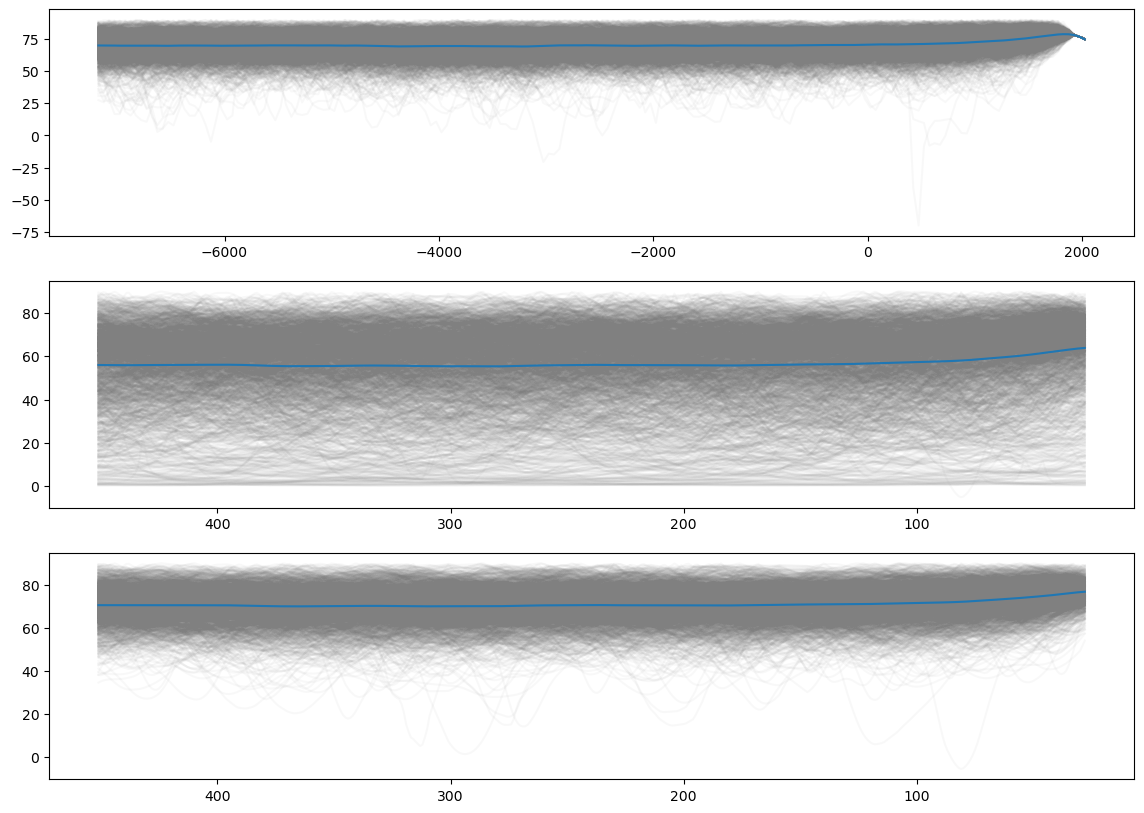

In [144]:
from constants import tDir
from data_handling import unshallow_inc
rI_sed = iData.posterior.rI_sed_U1305.values.reshape(-1, len(sed_data))
factor = np.sqrt(sed.errs_I + tDir**2)
I_sed = rI_sed * factor + sed.out_I
I_sed_unshallowd = np.array([unshallow_inc(I_sed[i], f_shallows[i]) for i in range(2000)])

fig, axs = plt.subplots(3, 1, figsize=(14, 10))
axs[0].plot(mcmc_knots, i_s, c="gray", alpha=0.05)
axs[0].plot(mcmc_knots, np.mean(i_s, axis=1), c="C0")
axs[1].plot(sed.depth, I_sed.T, c="gray", alpha=0.05)
axs[1].plot(sed.depth, np.mean(I_sed, axis=0), c="C0")
axs[2].plot(sed.depth, I_sed_unshallowd.T, c="gray", alpha=0.05)
axs[2].plot(sed.depth, np.mean(I_sed_unshallowd, axis=0), c="C0")
axs[1].invert_xaxis()
axs[2].invert_xaxis()
plt.show()

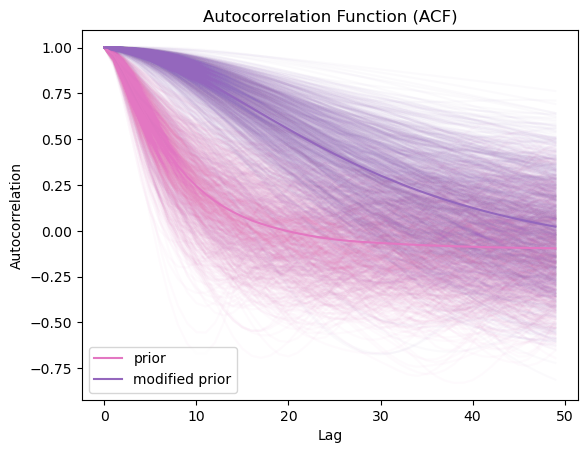

In [73]:
def compute_acf(series, max_lag):
    N = len(series)
    mu = np.mean(series)
    var = np.var(series)
    acf_vals = []
    for k in range(max_lag + 1):
        numerator = np.sum((series[:N-k] - mu) * (series[k:] - mu))
        acf_k = numerator / ((N - k) * var)
        acf_vals.append(acf_k)
    return acf_vals

n_lags = 50
# acf_values_shifted = compute_acf(I_sed.T[:, 0], max_lag=n_lags)
acf_shifted = np.array([compute_acf(I_sed.T[:, i], max_lag=n_lags-1) for i in range(1000)])
acf_normal = np.array([compute_acf(i_s[:, i], max_lag=n_lags-1) for i in range(1000)])
plt.plot(range(n_lags), acf_normal.T, c="C6", alpha=0.03)
plt.plot(range(n_lags), acf_shifted.T, c="C4", alpha=0.03)
plt.plot(range(n_lags), np.mean(acf_normal, axis=0), c="C6", zorder=3, label="prior")
plt.plot(range(n_lags), np.mean(acf_shifted, axis=0), c="C4", zorder=3, label="modified prior")
# plt.plot(range(len(acf_values_normal)), acf_values_normal, label="modified prior")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.legend()
plt.show()

In [22]:
gs_at_knots = iData.posterior[f'gs_at_knots'].values.reshape(-1, 35, 185)#.reshape(-1, 35, 161)
gs_at_knots_full = iData_full.posterior[f'gs_at_knots'].values.reshape(-1, 35, 185)#.reshape(-1, 35, 161)
# gs_at_knots_t_samp = np.array(iData_t_samp.posterior[f'gs_at_knots']).reshape(-1, 35, 281)

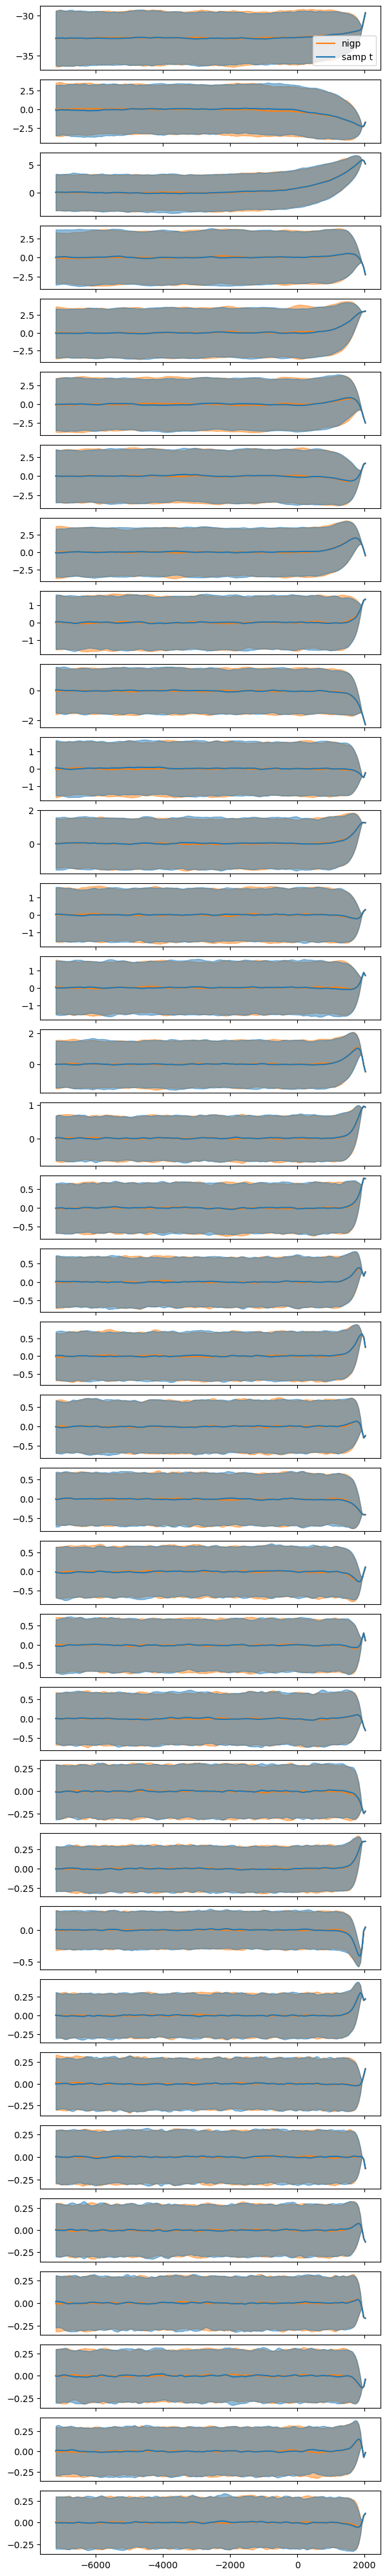

In [24]:
from scipy.interpolate import BSpline
t_min=min(min(sed_data.t), -6000) - 1000
t_max=2000
step=50
mcmc_knots = np.arange(t_min, t_max+50, 50)
fig, axs = plt.subplots(35, figsize=(6, 40), sharex=True)
fig.tight_layout(h_pad=0.02)
for i in range(35):
    gs_mean = gs_at_knots[:, i, :].mean(axis=0)
    gs_std = gs_at_knots[:, i, :].std(axis=0)
    # gs_mean_samp_t = gs_at_knots_t_samp[:, i, 281 - 161:].mean(axis=0)
    # gs_std_samp_t = gs_at_knots_t_samp[:, i, 281 - 161:].std(axis=0)
    gs_mean_samp_t = gs_at_knots_full[:, i, :].mean(axis=0)
    gs_std_samp_t = gs_at_knots_full[:, i, :].std(axis=0)
    axs[i].plot(mcmc_knots, gs_mean, label="nigp", c="C1")
    axs[i].fill_between(mcmc_knots, gs_mean - gs_std, gs_mean + gs_std, color="C1", alpha=0.5)
    axs[i].plot(mcmc_knots, gs_mean_samp_t, label="samp t", c="C0")
    axs[i].fill_between(mcmc_knots, gs_mean_samp_t - gs_std_samp_t, gs_mean_samp_t + gs_std_samp_t, color="C0", alpha=0.5)
axs[0].legend()
plt.show()

In [37]:
# for i in range(4):
#     plt.hist(
#         np.array(iData.posterior[f'rF_a'])[i].flatten(),
#         bins=np.linspace(-5, 5, 31)
#     )